In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Muat data dari file CSV dengan delimiter ;
df_customer = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df_store = pd.read_csv('Case Study - Store.csv', delimiter=';')
df_product = pd.read_csv('Case Study - Product.csv', delimiter=';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

# # Gabungkan df_transaction dengan df_customer, df_store, dan df_product berdasarkan ID yang sesuai
df = df_transaction.merge(df_customer, on='CustomerID', how='left').merge(df_store, on='StoreID', how='left').merge(df_product, on='ProductID', how='left')

In [26]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR16356,165,01/01/2022,P9,10000,7,70000,1,44,1,Married,"14,58",Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",Yoghurt,10000
2,TR1984,183,01/01/2022,P1,8800,4,35200,4,27,1,Single,"0,18",Gita Ginara,Gita,General Trade,"-6,966667","110,416664",Choco Bar,8800
3,TR35256,160,01/01/2022,P1,8800,7,61600,4,48,1,Married,"12,57",Gita Ginara,Gita,General Trade,"-6,966667","110,416664",Choco Bar,8800
4,TR41231,386,01/01/2022,P9,10000,1,10000,4,33,0,Married,"6,95",Gita Ginara,Gita,General Trade,"-6,966667","110,416664",Yoghurt,10000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

In [28]:
df.isna().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
Price_y            0
dtype: int64

In [29]:
df.duplicated().sum()

0

In [30]:
# Mengonversi kolom 'Income' ke numerik
df['Income'] = df['Income'].str.replace(',', '').astype(float)

# Menghapus kolom 'Price_y' karena sama dengan 'Price_x'
df = df.drop('Price_y', axis=1)

# Mengisi nilai yang hilang pada 'Marital Status'
mode_value = df['Marital Status'].mode()[0]
df['Marital Status'].fillna(mode_value, inplace=True)

In [31]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Feature Engineering
df['ProductID_count'] = df['ProductID'].count()
df['AmountPerProduct'] = df['TotalAmount'] / df['ProductID_count']
df['ProductID_nunique'] = df['ProductID'].nunique()
df['CustomerID_nunique'] = df['CustomerID'].nunique()
df['ProductToCustomerRatio'] = df['ProductID_nunique'] / df['CustomerID_nunique']
df['IncomeToAmount'] = df['Income'] / df['TotalAmount']
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['WeekOfYear'] = df['Date'].dt.weekofyear
df['Quarter'] = df['Date'].dt.quarter
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
df['AmountPerQty'] = df['TotalAmount'] / df['Qty']
df['QtyToPrice'] = df['Qty'] / df['Price_x']

# Fungsi agregasi
aggregation_functions = {
    'TransactionID': ['count', 'nunique'],
    'CustomerID': ['count', 'nunique'],
    'ProductID': ['count', 'nunique'],
    'StoreID': ['count', 'nunique'],
    'Age': ['mean', 'std', 'min', 'max', 'median', lambda x: x.mode()[0]],
    'Income': ['mean', 'std', 'median', 'max', 'min'],
    'Qty': ['sum', 'mean'],
    'TotalAmount': ['sum', 'mean', 'std', 'max', 'min', 'median'],
    'Price_x': ['mean', 'std', 'median', 'max', 'min'],
    'Gender': ['mean', 'sum'],
    'Marital Status': [lambda x: (x == 'Married').mean(), lambda x: (x == 'Single').mean()],
    'AmountPerProduct': 'mean',
    'ProductToCustomerRatio': 'mean',
    'IncomeToAmount': 'mean',
    'Month': 'first',
    'Day': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'mean',
    'WeekOfYear': 'first',
    'Quarter': 'first',
    'IsMonthStart': 'sum',
    'IsMonthEnd': 'sum',
    'AmountPerQty': 'mean',
    'QtyToPrice': 'mean'
}
aggregated_features = df.groupby('Date').agg(aggregation_functions).reset_index()
aggregated_features.columns = ['_'.join(col).strip() if col[1] else col[0] for col in aggregated_features.columns.values]

# One-hot encoding
ohe_columns = ['ProductID', 'Age', 'StoreID', 'StoreName', 'GroupStore', 'Type', 'Latitude', 'Longitude', 'Marital Status', 'Gender', 'Product Name']
ohe_features = pd.get_dummies(df[['Date'] + ohe_columns], columns=ohe_columns)
ohe_features = ohe_features.groupby('Date').sum().reset_index()

# Merging features
final_features = pd.merge(aggregated_features, ohe_features, on='Date', how='left')

final_features['Date'] = pd.to_datetime(final_features['Date'], format='%d/%m/%Y')
final_features.sort_values(by='Date', inplace=True)
final_features.set_index("Date", inplace=True)

# Metrik Hasil Metode Rounding:
# -------------------------------
# MAE     : 0.6066
# MSE     : 0.8689
# RMSE    : 0.9321
# MAPE    : 1.2844%
# SMAPE   : 1.2922%
# R-squared: 0.9957
# -------------------------------

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

<AxesSubplot: xlabel='Date'>

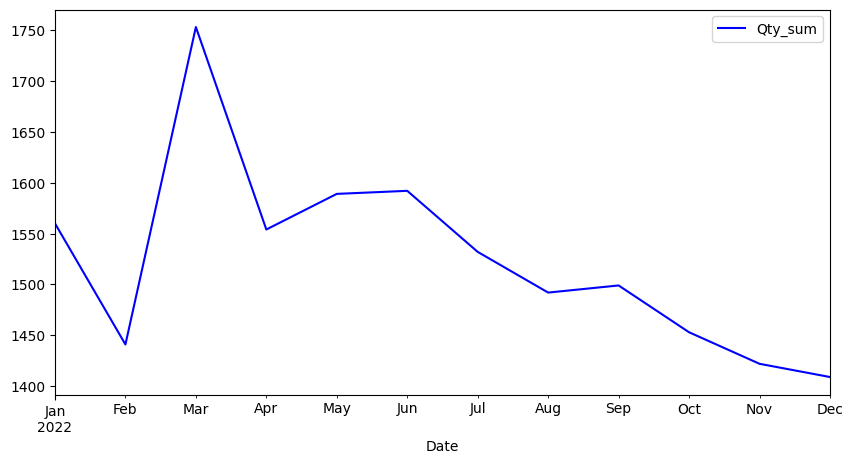

In [44]:
final_features.Qty_sum.resample('M').sum().plot( color='b', legend=True)

<AxesSubplot: xlabel='Date'>

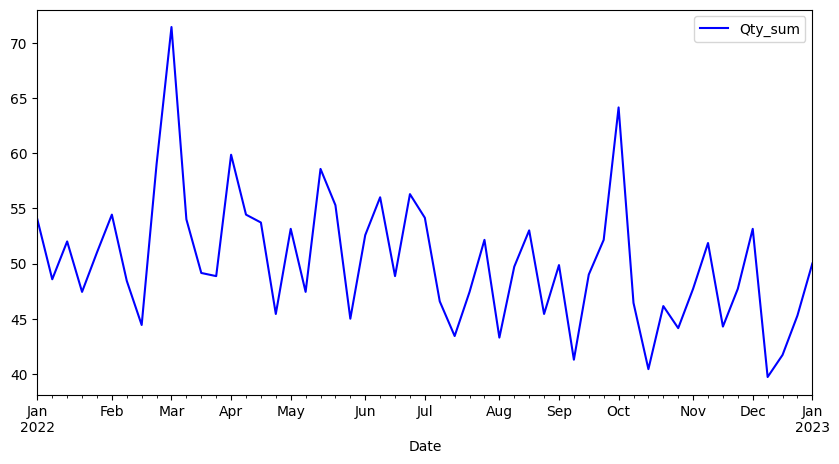

In [34]:
final_features.Qty_sum.resample('W').mean().plot( color='b', legend=True)

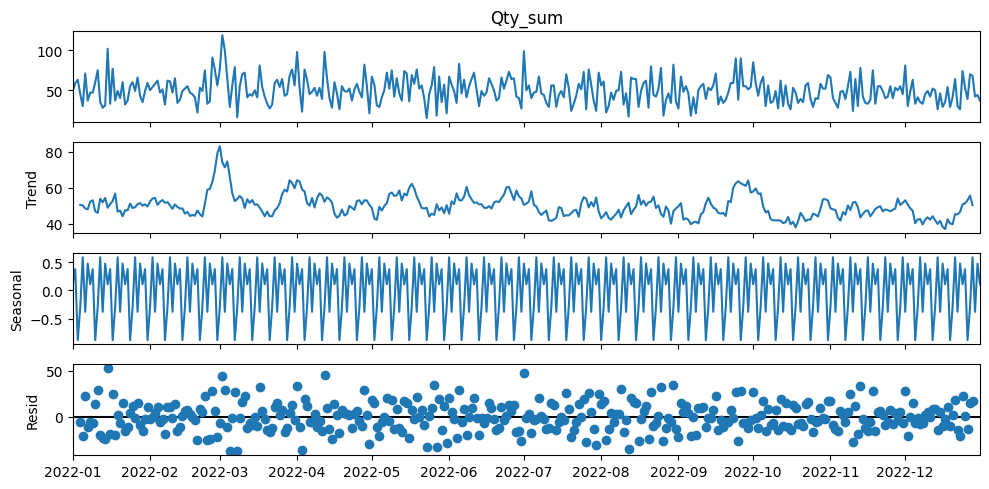

In [35]:
# Melakukan seasonal decomposition
result = seasonal_decompose(final_features['Qty_sum'].resample('D').mean(), model='additive')

# Membuat plot
result.plot()
plt.show()


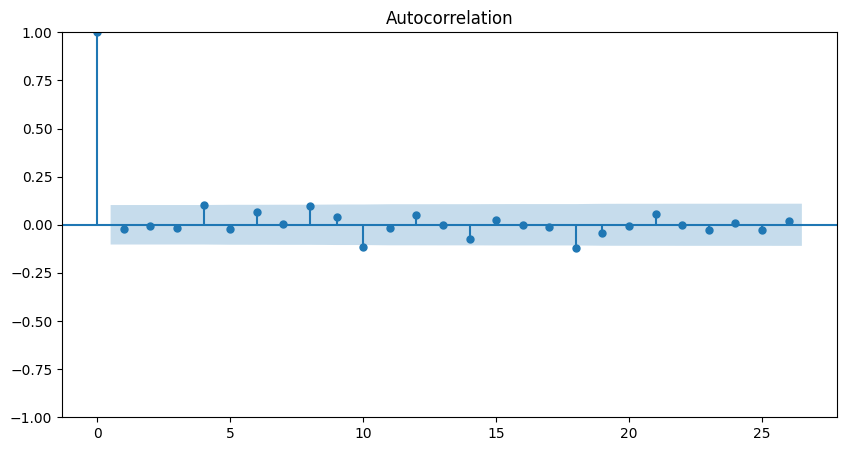

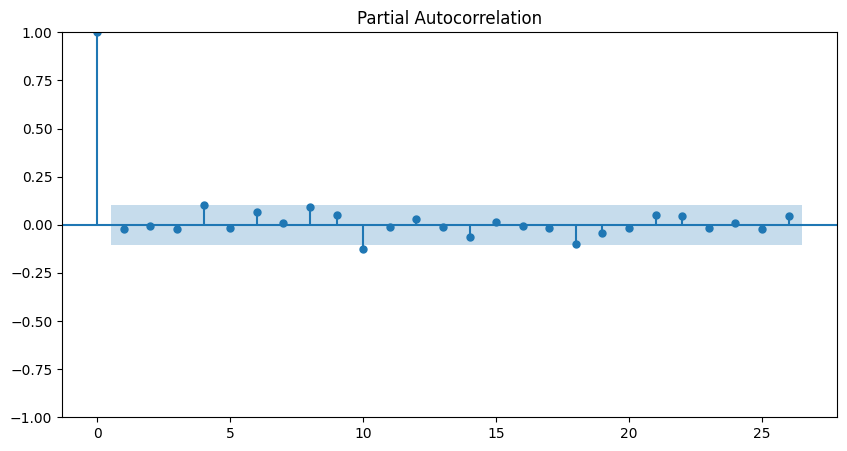

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(final_features['Qty_sum'])
plt.show()

plot_pacf(final_features['Qty_sum'])
plt.show()


In [37]:
# Split data menjadi training dan testing
train = final_features[:-61]
test = final_features[-61:]

# Menentukan variabel endogen (target) dan eksogen (fitur lainnya)
endog = train['Qty_sum']
exog = train.drop('Qty_sum', axis=1)

test_endog = test['Qty_sum']
test_exog = test.drop('Qty_sum', axis=1)

# Model SARIMAX
model = sm.tsa.statespace.SARIMAX(endog=endog,
                                  exog=exog,
                                  order=(0, 0, 0),  # Parameter untuk ARIMA
                                  seasonal_order=(1, 0, 1, 12),  # Parameter musiman dengan s = 12 (bulanan)
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# Prediksi
pred = results.get_prediction(start=pd.to_datetime(test.index[0]), 
                              end=pd.to_datetime(test.index[-1]),
                              exog=test_exog)
predicted_qty = pred.predicted_mean
actual_qty = test_endog

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                    Qty_sum   No. Observations:                  304
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -183.841
Date:                    Sat, 14 Oct 2023   AIC                            819.683
Time:                            14:52:12   BIC                           1649.854
Sample:                        01-01-2022   HQIC                          1152.253
                             - 10-31-2022                                         
Covariance Type:                      opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
TransactionID_count             0.0712      0.025      2.818      0.005       0.022       0.121
TransactionID_nunique           0.0769      0.025      3.082      0.002       0.028       0.126
CustomerID_count                0.0717      0.027      2.653      0.008       0.019       0.125
CustomerID_nunique              0.0833      0.197      0.424      0.672      -0.302       0.469
ProductID_count                 0.0713      0.024      2.941      0.003       0.024       0.119
ProductID_nunique              -0.0150      0.079     -0.189      0.850      -0.170       0.140
StoreID_count                   0.0713      0.026      2.698      0.007       0.020       0.123
StoreID_nunique                -0.0012      0.057     -0.021      0.984      -0.113       0.111
Age_mean                       -0.0590      0.074     -0.797      0.425      -0.204       0.086
Age_std                         0.0034      0.097      0.034      0.972      -0.187       0.194
Age_min                         0.0554      0.038      1.451      0.147      -0.019       0.130
Age_max                         0.0012      0.035      0.035      0.972      -0.067       0.070
Age_median                      0.0156      0.035      0.449      0.654      -0.053       0.084
Age_<lambda_0>                  0.0031      0.007      0.467      0.641      -0.010       0.016
Income_mean                     0.0005      0.001      0.341      0.733      -0.002       0.003
Income_std                     -0.0013      0.002     -0.737      0.461      -0.005       0.002
Income_median                  -0.0001      0.001     -0.147      0.883      -0.002       0.001
Income_max                      0.0002      0.000      0.575      0.565      -0.000       0.001
Income_min                     -0.0007      0.001     -0.791      0.429      -0.002       0.001
Qty_mean                       12.3924      0.398     31.123      0.000      11.612      13.173
TotalAmount_sum              8.877e-05   3.55e-06     24.986      0.000    8.18e-05    9.57e-05
TotalAmount_mean               -0.0010   6.21e-05    -16.082      0.000      -0.001      -0.001
TotalAmount_std             -8.999e-05   4.36e-05     -2.062      0.039      -0.000   -4.45e-06
TotalAmount_max               1.95e-05    1.3e-05      1.503      0.133   -5.92e-06    4.49e-05
TotalAmount_min             -4.475e-05   2.81e-05     -1.590      0.112   -9.99e-05    1.04e-05
TotalAmount_median          -3.013e-05   1.81e-05     -1.661      0.097   -6.57e-05    5.42e-06
Price_x_mean                    0.0017      0.000     13.766      0.000       0.001       0.002
Price_x_std                  5.003e-05      0.000      0.205      0.837      -0.000       0.001
Price_x_median                1.12e-05    7.5e-05      0.149      0.881      -0.000       0.000
Price_x_max                 -6.566e-05   9.27e-05     -0.708      0.479      -0.000       0.000
Price_x_min                  9.496e-0

In [39]:
def smape(true, predicted):
    return 100 * np.mean(2 * np.abs(predicted - true) / (np.abs(true) + np.abs(predicted)))

# Fungsi untuk menghitung metrik
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=False)
    mape = (100 * (abs(actual - predicted) / predicted)).mean()
    smape_value = smape(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    return mae, mse, rmse, mape, smape_value, r2

In [45]:
# Metode Rounding Normal
predicted_qty_round = predicted_qty.apply(round)

# Menghitung metrik untuk setiap metode rounding
mae_round, mse_round, rmse_round, mape_round, smape_round, r2_round = calculate_metrics(actual_qty, predicted_qty_round)

# Mencetak hasil dengan formatting yang rapi
outcome = f"""
Metrik Hasil:
-------------------------------
MAE     : {mae_round:.4f}
MSE     : {mse_round:.4f}
RMSE    : {rmse_round:.4f}
MAPE    : {mape_round:.4f}%
SMAPE   : {smape_round:.4f}%
R-squared: {r2_round:.4f}
-------------------------------
"""

print(outcome)


Metrik Hasil:
-------------------------------
MAE     : 0.6230
MSE     : 0.8197
RMSE    : 0.9054
MAPE    : 1.3854%
SMAPE   : 1.3860%
R-squared: 0.9959
-------------------------------



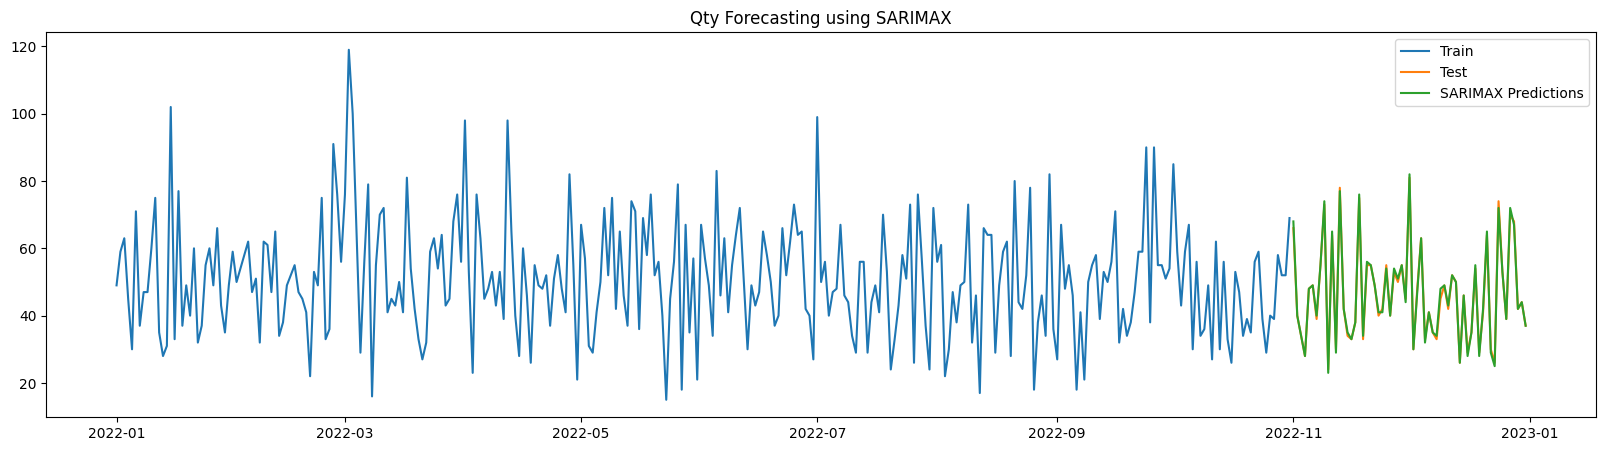

In [41]:
# Plot aktual vs prediksi
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['Qty_sum'], label='Train')
plt.plot(test.index, actual_qty, label='Test')
plt.plot(test.index, predicted_qty_round, label='SARIMAX Predictions')
plt.legend(loc='best')
plt.title('Qty Forecasting using SARIMAX')
plt.show()


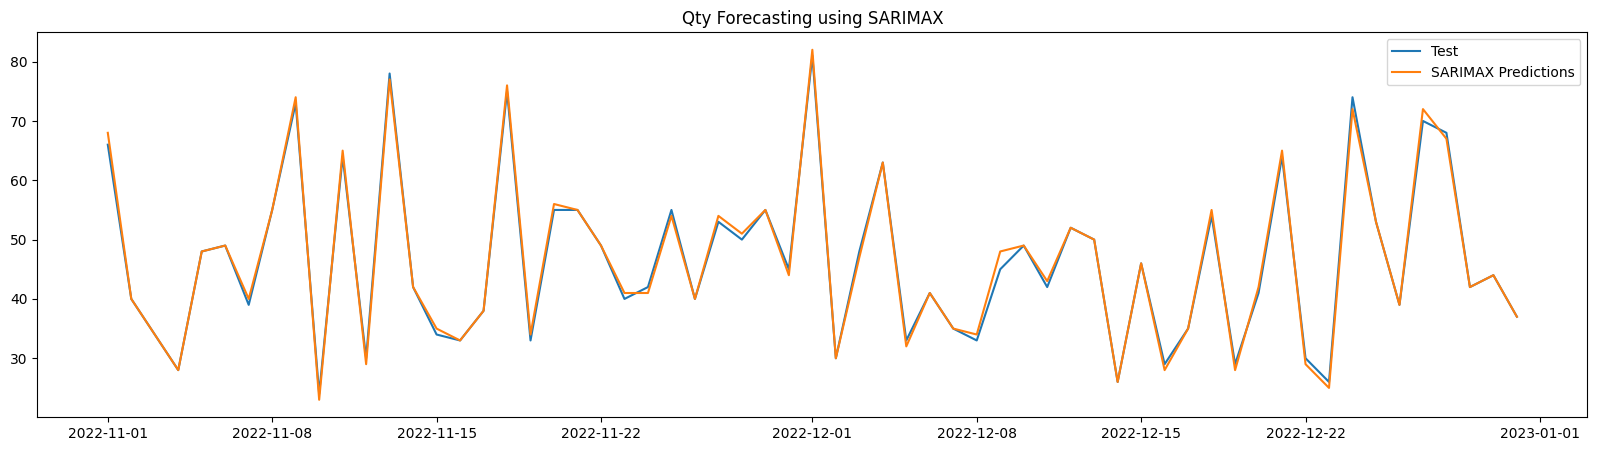

In [42]:
# Plot aktual vs prediksi
plt.figure(figsize=(20, 5))
plt.plot(test.index, actual_qty, label='Test')
plt.plot(test.index, predicted_qty_round, label='SARIMAX Predictions')
plt.legend(loc='best')
plt.title('Qty Forecasting using SARIMAX')
plt.show()